# YamboWorkflow: a full DFT+MBPT flow - BSE version

In this notebook we will compute the BSE absorption spectrum and excitonic eigenvalues by means of the `YamboWorkflow` workchain of the plugin.
We are going to compute exciton starting from a scissor and stretching correction for the DFT eigenvalues. In the next tutorial we will see how to 
compute G0W0 correction in order to perform BSE@G0W0.

In [40]:
from aiida import orm, load_profile
load_profile()

from aiida.plugins import WorkflowFactory
from aiida.orm import QueryBuilder
from aiida.engine import submit

from aiida_quantumespresso.common.types import ElectronicType

import yaml

qb = QueryBuilder()
qb.append(orm.Group, filters={'label': 'Silicon/bulk'}, tag='group')
qb.append(orm.StructureData, with_group='group')

loaded_structure_id = qb.all()[0][0].pk

# Read YAML file
with open("../configuration/codes_localhost.yaml", 'r') as stream:
    codes = yaml.safe_load(stream)
    
with open("../configuration/resources_localhost.yaml", 'r') as stream:
    resources = yaml.safe_load(stream)
    
options = {
    'pseudo_family':"PseudoDojo/0.4/PBE/SR/standard/upf",
    'protocol':'fast',
    #'parent_id':274, #not necessary to set; if you want it, take ytheour previously nscf id (pk) to skip the DFT part.
    'structure_id':loaded_structure_id,
}

YamboWorkflow = WorkflowFactory('yambo.yambo.yambowf')

builder = YamboWorkflow.get_builder_from_protocol(
            pw_code = codes['pwcode_id'],
            preprocessing_code = codes['yamboprecode_id'],
            code = codes['yambocode_id'],
            protocol=options['protocol'],
            protocol_qe=options['protocol'],
            structure= orm.load_node(options['structure_id']),
            overrides={
                'yres': {"yambo": {
                    "parameters": {
                        "variables": {
                            "NGsBlkXp": [4, "Ry"],
                            "FFTGvecs": [24, "Ry"],
                            },
                        },
                    },
                }
            },
            pseudo_family= options['pseudo_family'],
            #parent_folder=orm.load_node(options['parent_id']).outputs.remote_folder,
            electronic_type=ElectronicType.INSULATOR, #default is METAL: in that case, smearing is used
            calc_type='bse', #or 'bse'; default is 'gw'
)

builder.scf.pw.metadata.options = resources

builder.nscf.pw.metadata.options = builder.scf.pw.metadata.options
builder.yres.yambo.metadata.options = builder.scf.pw.metadata.options

Summary of the main inputs:
BndsRnXs = 150
NGsBlkXs = 2 Ry
BSENGBlk = 2 Ry
FFTGvecs = 24 Ry


kpoint mesh for nscf: [6, 6, 6]


For BSE simulation, it is crucial to explicitely put the parallelism instructions in the input parameters.
It can be done in the overrides, or we can also re-define the variable `builder.yres.yambo.parameters`:

In [41]:
builder.yres.yambo.parameters = orm.Dict(
    dict={'arguments':['em1s','bse','bss','optics', 'dipoles',],
                'variables':{
                'BSEmod': 'resonant',
                'BSKmod': 'SEX',
                'BSSmod': 'd',
                'Lkind': 'full',
                'NGsBlkXs': [4, 'Ry'],
                'BSENGBlk': [4, 'Ry'],
                'Chimod': 'hartree',
                'DysSolver': 'n',
                'BEnSteps': [10,''],
                'BSEQptR': [[1,1],''],
                'BSEBands': [[4,5],''],
                'BEnRange': [[0.0, 20.0],'eV'],
                'BDmRange': [[0.1, 0.1],'eV'],
                'BLongDir': [[1.0, 1.0, 1.0],''],
                'LongDrXp': [[1.0, 1.0, 1.0],''],
                'LongDrXd': [[1.0, 1.0, 1.0],''],
                'LongDrXs': [[1.0, 1.0, 1.0],''],
                'BndsRnXs': [[1,100], ''],
                'KfnQP_E':[[0.5,1,1],''],           # <== Scissor and stretching correction.
                'BS_CPU':'1 1 1',     # <== PARALLELISM INFO
                'BS_ROLEs':'k eh t',                # <== PARALLELISM INFO
                },}
)

### Requesting the YamboWorkflow to compute a specific quantity: the lowest and brightest excitons.

This is the same input that we provided in the [`3_YamboWorkflow_G0W0`](3_1_YamboWorkflow_G0W0.ipynb) tutorial, but here we ask for excitons:

In [42]:
builder.additional_parsing = orm.List(list=['lowest_exciton','brightest_exciton'])

#### Submission

In [43]:
run = None

In [44]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

/home/max/.conda/envs/aiida/lib/python3.9/site-packages/aiida_quantumespresso/calculations/pw.py:211: UserWarning: `parent_folder` not provided for `nscf` calculation. For work chains wrapping this calculation, you can disable this warning by excluding the `parent_folder` when exposing the inputs of the `PwCalculation`.
  warnings.warn(


uuid: 8f227227-475b-47db-9034-53475995660b (pk: 739) (aiida.workflows:yambo.yambo.yambowf)


## Inspecting the outputs

suppose that your calculation completed successfully, then you can access the outputs via the output method of the run instance. All the outputs of YamboRestart and YamboCalculation are inherited

In [45]:
run.is_finished_ok

False

In [49]:
!verdi process report {run.pk}

2024-02-19 15:32:22 [138 | REPORT]: [739|YamboWorkflow|start_workflow]: no previous pw calculation found, we will start from scratch
2024-02-19 15:32:22 [139 | REPORT]: [739|YamboWorkflow|start_workflow]:  workflow initilization step completed.
2024-02-19 15:32:23 [140 | REPORT]: [739|YamboWorkflow|can_continue]: the workflow continues with a scf calculation
2024-02-19 15:32:23 [141 | REPORT]: [739|YamboWorkflow|perform_next]: performing a scf calculation
2024-02-19 15:32:24 [142 | REPORT]:   [740|PwBaseWorkChain|run_process]: launching PwCalculation<745> iteration #1
2024-02-19 15:32:30 [143 | REPORT]:   [740|PwBaseWorkChain|results]: work chain completed after 1 iterations
2024-02-19 15:32:30 [144 | REPORT]:   [740|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
2024-02-19 15:32:30 [145 | REPORT]: [739|YamboWorkflow|can_continue]: the workflow continues with a nscf calculation
2024-02-19 15:32:30 [146 | REPORT]: [739|YamboWorkflow|perform_next]: performing a nscf c

In [50]:
run.outputs.output_ywfl_parameters.get_dict()

{'lowest_exciton': 2.9510221481323,
 'brightest_exciton': 20.251094818115,
 'lowest_exciton_index': 1,
 'brightest_exciton_index': 216}

In [51]:
!verdi process show {run.pk}

Property     Value
-----------  ------------------------------------
type         YamboWorkflow
state        Finished [0]
pk           739
uuid         8f227227-475b-47db-9034-53475995660b
label
description
ctime        2024-02-19 15:32:21.519540+01:00
mtime        2024-02-19 15:33:47.259290+01:00

Inputs                      PK    Type
--------------------------  ----  -------------
nscf
    pw
        pseudos
            Si              331   UpfData
        code                1     InstalledCode
        structure           371   StructureData
        parameters          723   Dict
    clean_workdir           724   Bool
    kpoints_distance        725   Float
    kpoints_force_parity    726   Bool
    kpoints                 727   KpointsData
    max_iterations          728   Int
scf
    pw
        pseudos
            Si              331   UpfData
        code                1     InstalledCode
        structure           371   StructureData
        parameters          718   Dict
  

### Plotting the BSE absorption spectrum

In [52]:
array_chi = run.outputs.array_chi

In [53]:
array_chi.get_arraynames()

['eV', 'eps_1', 'eps_2']

In [54]:
energy = array_chi.get_array("eV")
epsilon2 = array_chi.get_array("eps_2")

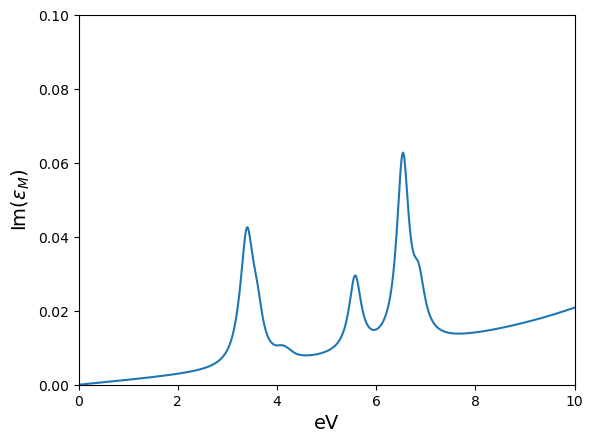

In [63]:
import matplotlib.pyplot as plt

plt.xlim(0,10)
plt.ylim(0,0.1)
plt.xlabel("eV",fontsize=14)
plt.ylabel("Im($\epsilon_M$)",fontsize=14)
plt.plot(energy,epsilon2)

Up to now, only the BSE absorption and loss spectra can be plotted: the RPA-IP spectra are not saved in the repository.
However, they can be easily generated using yambopy functions, once the BSE database is loaded. If you are already and expert of `yambopy`, you can try to do it by using the trick used to obtain the raw ndb.QP_fixed file in previous step of the tutorial on YamboWorkflow.